<a href="https://colab.research.google.com/github/nataliarigol/MathData24/blob/main/my_project_ncr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
data_dir = '/content/drive/My Drive/clean vs. polluted rivers/'

In [45]:
dataset_labels = ["clean", "polluted"]

In [46]:
from torchvision import transforms

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [47]:
from torchvision import datasets
import torch

def create_dataloaders(data_dir, batch_size=16):
    image_datasets = {
        x: datasets.ImageFolder(
            os.path.join(data_dir, x),
            data_transforms[x]
        ) for x in ['train', 'valid']
    }

    dataloaders = {
        x: torch.utils.data.DataLoader(
            image_datasets[x],
            batch_size=batch_size,
            shuffle=True,
            num_workers=2
        ) for x in ['train', 'valid']
    }

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
    class_names = image_datasets['train'].classes

    return dataloaders, dataset_sizes, class_names

dataloaders, dataset_sizes, class_names = create_dataloaders(data_dir)

In [48]:
import torchvision.models as models
import torch.nn as nn

model = models.alexnet(pretrained=True)

# Modify the last layer to match the number of classes
model.classifier[6] = nn.Linear(4096, len(class_names))

# Set the model to use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [49]:
import torch.optim as optim
from torch.optim import lr_scheduler

def train_model(model, dataloaders, dataset_sizes, num_epochs=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_corrects += torch.sum(preds == labels.data)

            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase.capitalize()} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                scheduler.step()

        print()

    return model

model = train_model(model, dataloaders, dataset_sizes)

Epoch 1/3
----------
Train Acc: 0.7308
Valid Acc: 0.9000

Epoch 2/3
----------
Train Acc: 0.9231
Valid Acc: 1.0000

Epoch 3/3
----------
Train Acc: 0.9744
Valid Acc: 1.0000



In [50]:
torch.save(model.state_dict(), 'clean_polluted_river_model.pth')

In [51]:
model.load_state_dict(torch.load('clean_polluted_river_model.pth'))
model.eval()

<ipython-input-51-c71f8157d41a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('clean_polluted_river_model.pth'))


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

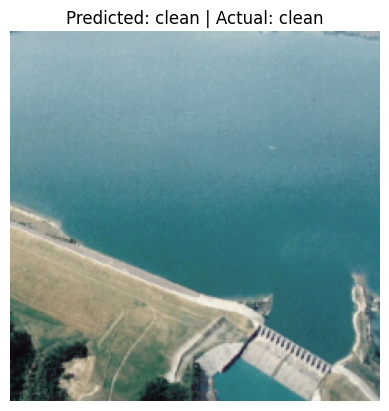

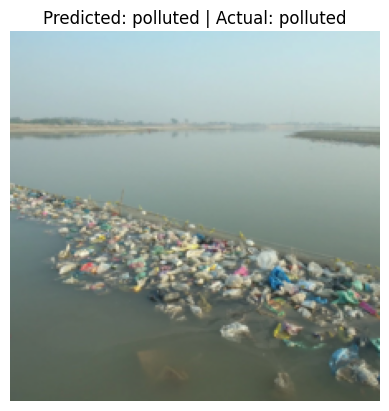

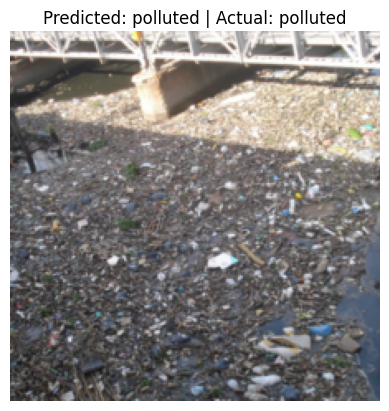

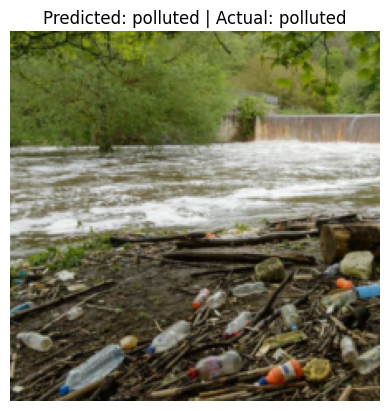

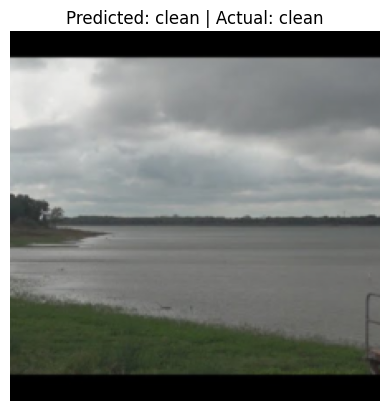

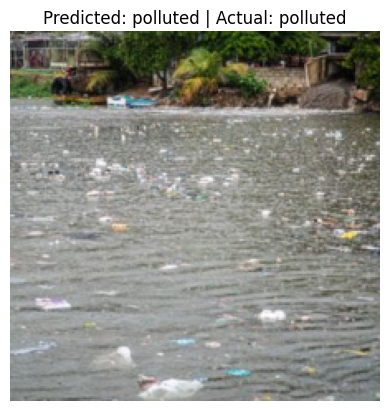

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def visualize_model(model, dataloaders, num_images=6):
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['valid']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                imshow(inputs.cpu().data[j], title=f'Predicted: {dataset_labels[preds[j]]} | Actual: {dataset_labels[labels[j]]}')
                if images_so_far == num_images:
                    return

visualize_model(model, dataloaders)

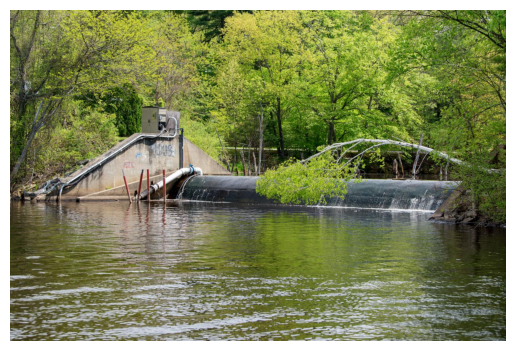

In [56]:
#TESTING
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the image in Google Drive
image_path = '/content/drive/My Drive/aaaaaaaaaa.jpg'  # Update this path if your image is in a different folder

# Open and display the image
image = Image.open(image_path)

plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

In [57]:
from torchvision import transforms
import torch

# Define the transformations
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Apply transformations to the image and add a batch dimension
image_tensor = test_transforms(image).unsqueeze(0).to(device)

# Make predictions
model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient calculation for inference
    outputs = model(image_tensor)
    _, preds = torch.max(outputs, 1)

print(f'Predicted: {dataset_labels[preds[0]]}')

Predicted: clean


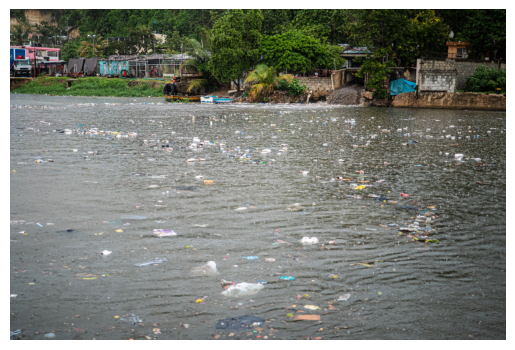

In [58]:
# Define the path to the image in Google Drive
image_path = '/content/drive/My Drive/bbbbbbb.jpg'  # Update this path if your image is in a different folder

# Open and display the image
image = Image.open(image_path)

plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

In [59]:
# Define the transformations
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Apply transformations to the image and add a batch dimension
image_tensor = test_transforms(image).unsqueeze(0).to(device)

# Make predictions
model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient calculation for inference
    outputs = model(image_tensor)
    _, preds = torch.max(outputs, 1)

print(f'Predicted: {dataset_labels[preds[0]]}')

Predicted: polluted
